# Imports


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import statsmodels.tools 
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('max_colwidth',99999)

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA 

In [3]:
##!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer

In [4]:
## !pip install plotnine

In [5]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

In [6]:
new_df=pd.read_csv('Data/index_df.csv')

# Data prep


In [7]:
#keep complete cases only
full=new_df[['Country Name', 'Country Code', 'Continent', 'Year', 
       'Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX',
       'Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS',
       'pol_gen', 'exl_gen', 'exl_eco', 'exl_geo', 'exl_pol', 'exl_soc',
       'labour_share',
       'suffrage_f', 'domestic_movement', 'slave', 'suffrage', 'v2xeg_eqaccess']].dropna(axis = 0, how = 'any')

In [8]:
#extract feature columns
features_df=new_df[[ 
       'Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX',
       'Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS',
       'pol_gen', 'exl_gen', 'exl_eco', 'exl_geo', 'exl_pol', 'exl_soc',
       'labour_share',
       'suffrage_f', 'domestic_movement', 'slave', 'suffrage', 'v2xeg_eqaccess']].dropna(axis = 0, how = 'any')

In [9]:
#standardise variables
scaler = StandardScaler()

scaled_df=features_df.copy()
scaled_df=pd.DataFrame(scaler.fit_transform(scaled_df))
scaled_df.head()

0         1         2         3         4         5         6   \
0 -0.487836 -0.292179 -1.740186 -1.482210 -1.858440 -2.310215 -1.692812   
1  0.505710 -1.198256 -0.469459  0.142761  0.238470  0.813579 -0.067604   
2 -2.510411 -1.652585 -3.212216 -1.250720 -0.189551  0.038592 -1.038950   
3 -0.345901  0.676515  0.631418  1.014254  0.379835  0.706273  1.115396   
4 -0.700738 -1.383803 -0.412842 -0.165893 -0.295574  0.277050  0.026885   

         7         8         9         10        11        12        13  
0 -2.157854 -4.520719  0.223870 -3.597094 -1.034540  0.223874 -1.625174  
1  0.440507  1.011332  0.223870  0.294444 -0.443768  0.223874  0.142144  
2 -1.606564  0.929951 -4.694858 -2.735437 -2.967976 -4.697879 -2.251390  
3  0.975582  0.132271  0.223870  0.880146  0.496097  0.223874  0.986375  
4  1.076922  0.483461  0.223870  0.829460  0.587398  0.223874 -0.664978

In [10]:
features_df.shape

(2545, 14)

#FA

Check for intercorrelations:

**Bartlett’s test of sphericity** checks whether or not the correlation is present in between the observed variables. It tests the null hypothesis (H0) that the observed correlation matrix is an Identical matrix - all the diagonal elements as 1 (no correlation is present among the variables). We want to reject this null hypothesis because factor analysis aims at explaining the common variance i.e. the variation due to correlation among the variables.

**Kaiser-Meyer-Olkin (KMO)** measures how suitable the data is for factor analysis. KMO score is always between 0 to 1. The larger the value, the larger the proportions of variance for the data, and the more applicable it is to use dimensionality reduction techniques such as Factor Analysis since it represents the presence of more correlation among the variables. The thumb of rule is that value should be at least more than 0.6. 


In [11]:
#Bartlett’s test of sphericity 
chi_square_value,p_value=calculate_bartlett_sphericity(scaled_df)
chi_square_value, p_value
#The p-value is zero so the test was statistically significant, there is a sufficient evidence to conclude that correlation is present among the variables with a 95% confidence level, we can apply factor analysis.

(61588.51413659158, 0.0)

In [12]:
#KMO 
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(scaled_df)
kmo_model
#The data has an overall proportion of variance of 0.86, indicating that the data has enough correlation and dimensionality reduction techniques such as the factor analysis can be applied.


/opt/anaconda3/lib/python3.8/site-packages/factor_analyzer/utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.8632173332539836

In [13]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
fa.fit(scaled_df)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([7.30817427e+00, 2.16869632e+00, 1.12357025e+00, 1.03154673e+00,
       7.07189866e-01, 3.84939437e-01, 3.48090824e-01, 3.01397033e-01,
       2.45757830e-01, 1.53261018e-01, 1.18023881e-01, 6.05154176e-02,
       4.88328871e-02, 4.23926580e-06])

## Select number of factors

Standard practice is to choose factors that: 

*    (i) have associated eigenvalues larger than one; 
*   (ii) contribute individually to the explanation of overall variance by more than 10%; and 


*   (iii) contribute
cumulatively to the explanation of the overall variance by more than 60%. 
Source: https://www.oecd.org/sdd/42495745.pdf

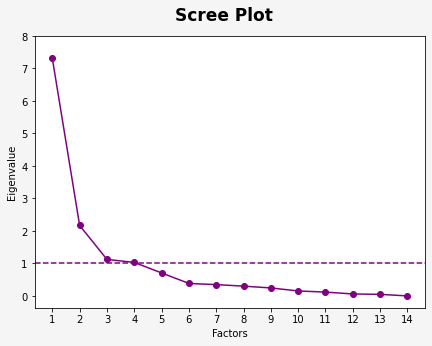

In [14]:
# Create scree plot using matplotlib to look at eigenvalues
fig, ax = plt.subplots(figsize=(7, 5),facecolor='#F5F5F5')
plt.scatter(range(1,scaled_df.shape[1]+1),ev,color='purple')
plt.plot(range(1,scaled_df.shape[1]+1),ev,color='purple')
plt.axhline(y=1, color='purple', linestyle='dashed')
Ystart, Yend = ax.get_ylim()
ax.text(5.5,Yend+0.8, 'Scree Plot', fontsize=17,fontweight='bold')
plt.xlabel('Factors')
plt.yticks(np.arange(min(ev), max(ev)+1, 1.0))
plt.xticks(np.arange(1, scaled_df.shape[1]+1, 1.0))
plt.ylabel('Eigenvalue')
#plt.grid()
plt.show()

The eigenvalues change less markedly when more than 6 factors are used. Therefore, at most 6 factors would be used. The scree plot shows that the first three factors account for most of the total variability in data. The remaining factors account for much smaller proportion of the variability and are likely unimportant.

In [15]:
facs = ['Factors' + ' ' + str(i + 1) for i in range(6)]
fa = FactorAnalyzer(n_factors=6,rotation=None) #6 factors are used
fa.fit(scaled_df)
load=pd.DataFrame(fa.loadings_,index=features_df.columns,columns=facs)

In [16]:
df_variance=pd.DataFrame(fa.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var'])

In [17]:
df_variance

0         1         2         3         4         5
Variance          7.154114  2.113002  0.951944  0.523289  0.193012  0.120720
Proportional Var  0.511008  0.150929  0.067996  0.037378  0.013787  0.008623
Cumulative Var    0.511008  0.661937  0.729933  0.767311  0.781097  0.789720

Definitions

*   **Variance (Eigenvalues)**
If you use principal components to extract factors, the variance equals the eigenvalue. You can use the size of the eigenvalue to determine the number of factors. Retain the factors with the largest eigenvalues. For example, using the Kaiser criterion, you use only the factors with eigenvalues that are greater than 1

*  **Percentage/Proportion of Var**
Use the percentage of variance (% Var) to determine the amount of variance that the factors explain. Retain the factors that explain an acceptable level of variance. The acceptable level depends on your application. 


*  **Scree plot**
The scree plot orders the eigenvalues from largest to smallest. The ideal pattern is a steep curve, followed by a bend, and then a straight line. Use the components in the steep curve before the first point that starts the line trend.






(iii) is the most important

*  (i) have associated eigenvalues larger than one **Factor 3 has an eignevalue close to one so I'll still keep it**
*  (ii) contribute individually to the explanation of overall variance by more than 10%; 
*  (iii) contribute cumulatively to the explanation of the overall variance by more than 60% **Factor 1-3 together explain 73% of the variance**

Therefore, we use factor 1-3






**Rotation**

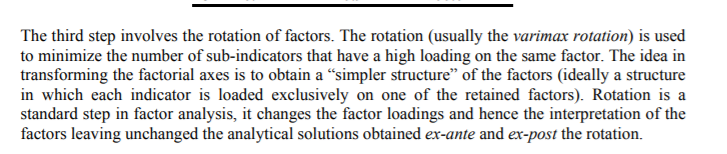

In [18]:
facs = ['Factors' + ' ' + str(i + 1) for i in range(6)]
fa = FactorAnalyzer(n_factors=6,rotation='varimax') #apply varimax rotation
fa.fit(scaled_df)
load=pd.DataFrame(fa.loadings_,index=features_df.columns,columns=facs)

In [19]:
load=load[['Factors 1', 'Factors 2', 'Factors 3']]

**Communality** measures the percent of variance in a given variable explained by all the factors jointly and may be interpreted as the reliability of the indicator in the context of the factors being posited.

In [20]:
arr=fa.get_communalities()
p=load.copy()
p['communalities'] = arr.tolist()

In [21]:
p

Factors 1  \
Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX               0.357890   
Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS   0.089894   
pol_gen                                                                          0.434151   
exl_gen                                                                          0.764850   
exl_eco                                                                          0.930576   
exl_geo                                                                          0.935222   
exl_pol                                                                          0.805425   
exl_soc                                                                          0.867755   
labour_share                                                                     0.006071   
suffrage_f                                                                       0.052205   
domestic_movement                                                                0.305369   
slave                                                                            0.285456   
suffrage                                                                         0.052294   
v2xeg_eqaccess                                                                   0.560453   

                                                                                Factors 2  \
Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX               0.494979   
Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS   0.212486   
pol_gen                                                                          0.760328   
exl_gen                                                                          0.441294   
exl_eco                                                                          0.214823   
exl_geo                                                                          0.163754   
exl_pol                                                                          0.249382   
exl_soc                                                                          0.321335   
labour_share                                                                     0.028120   
suffrage_f                                                                       0.225246   
domestic_movement                                                                0.727664   
slave                                                                            0.717030   
suffrage                                                                         0.225029   
v2xeg_eqaccess                                                                   0.557002   

                                                                                Factors 3  \
Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX               0.202418   
Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS   0.067291   
pol_gen                                                                          0.236999   
exl_gen                                                                          0.121433   
exl_eco                                                                         -0.015111   
exl_geo                                                                         -0.024388   
exl_pol                                                                          0.080017   
exl_soc                                                                          0.151460   
labour_share                                                                    -0.010449   
suffrage_f                                                                       0.968400   
domestic_movement                                                                0.281337   
slave                                                                            0.212368   
suffrage                                                                       

The way to interpret communalities:
source:https://online.stat.psu.edu/stat505/lesson/12/12.5
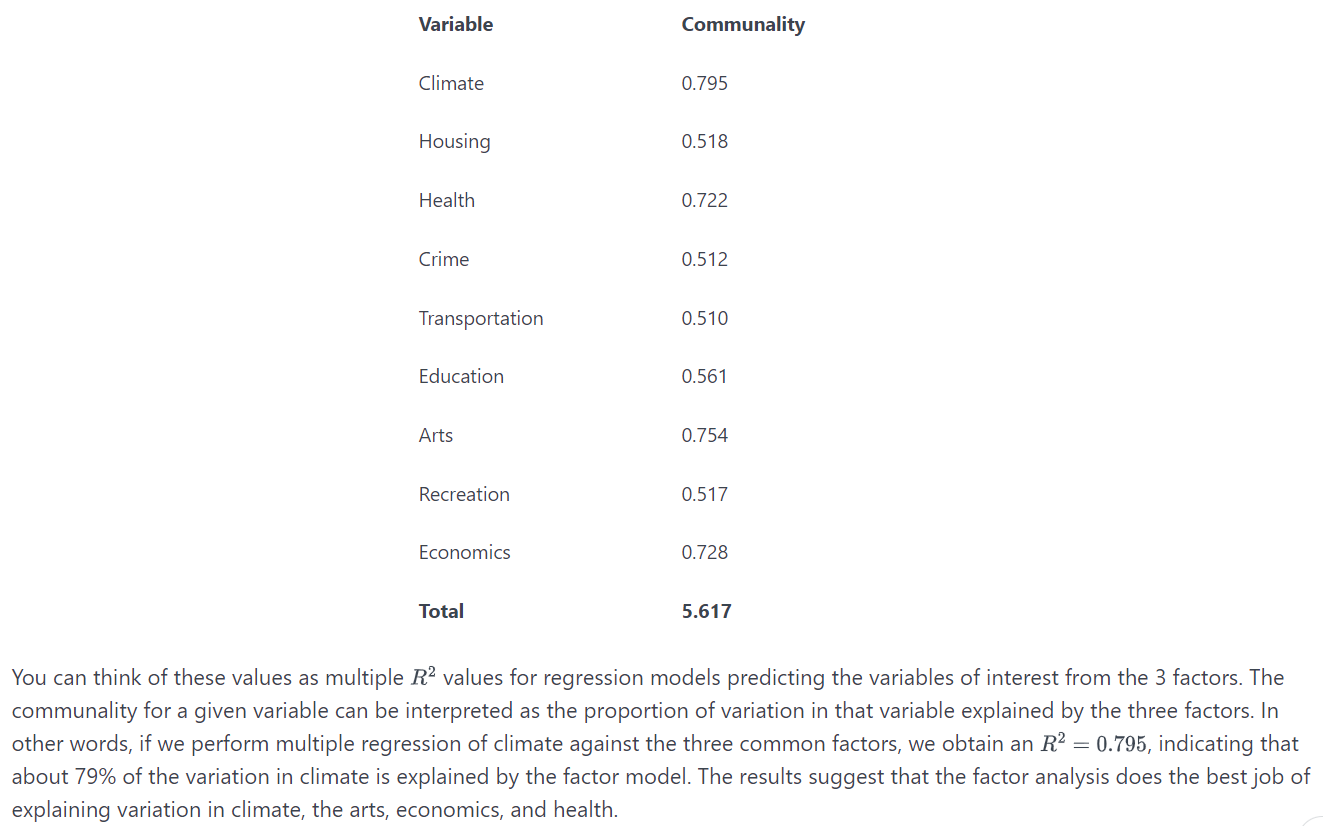

**Interpret communalities**
 The factor model explains almost the entirety of the variance in suffrage/Female suffrage. It does not however explain much of the variance in labour share, this may indicate that less importance is placed on income inequality in the index. I still kept this variable because it is the only variable which captures the time-variant economic conditions that affects equality

recreating this table:

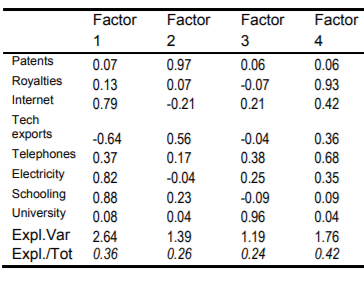

In [22]:
#calculate the variance explained for each factor
load.sum(axis=0).to_dict()

{'Factors 1': 6.44761115069493,
 'Factors 2': 5.338473103675901,
 'Factors 3': 3.381161488052422}

In [23]:
#calculate total variance explained 
load.sum(axis=0).to_frame().sum() 

0    15.167246
dtype: float64

In [24]:
#append row to the dataframe
new_row={'Factors 1': 6.447611152482793,
 'Factors 2': 5.338473135667066,
 'Factors 3': 3.3811614859401367}
load = load.append(new_row, ignore_index=True)
load

Factors 1  Factors 2  Factors 3
0    0.357890   0.494979   0.202418
1    0.089894   0.212486   0.067291
2    0.434151   0.760328   0.236999
3    0.764850   0.441294   0.121433
4    0.930576   0.214823  -0.015111
5    0.935222   0.163754  -0.024388
6    0.805425   0.249382   0.080017
7    0.867755   0.321335   0.151460
8    0.006071   0.028120  -0.010449
9    0.052205   0.225246   0.968400
10   0.305369   0.727664   0.281337
11   0.285456   0.717030   0.212368
12   0.052294   0.225029   0.968423
13   0.560453   0.557002   0.140963
14   6.447611   5.338473   3.381161

In [25]:
#calculate the proportion of the explained variance by each factor
#variance explained by each factor divided by total variance explained
new_row={'Factors 1': 6.447611152482793/15.167246,
 'Factors 2': 5.338473135667066/15.167246,
 'Factors 3': 3.3811614859401367/15.167246}

#append row to the dataframe
load = load.append(new_row, ignore_index=True)
load

Factors 1  Factors 2  Factors 3
0    0.357890   0.494979   0.202418
1    0.089894   0.212486   0.067291
2    0.434151   0.760328   0.236999
3    0.764850   0.441294   0.121433
4    0.930576   0.214823  -0.015111
5    0.935222   0.163754  -0.024388
6    0.805425   0.249382   0.080017
7    0.867755   0.321335   0.151460
8    0.006071   0.028120  -0.010449
9    0.052205   0.225246   0.968400
10   0.305369   0.727664   0.281337
11   0.285456   0.717030   0.212368
12   0.052294   0.225029   0.968423
13   0.560453   0.557002   0.140963
14   6.447611   5.338473   3.381161
15   0.425101   0.351974   0.222925

In [26]:
#add the variable names back to the dataframe
cols=['Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX',
       'Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS',
       'pol_gen', 'exl_gen', 'exl_eco', 'exl_geo', 'exl_pol', 'exl_soc',
       'labour_share', 'suffrage_f', 'domestic_movement', 'slave', 'suffrage',
       'v2xeg_eqaccess','var_explained','prop_var_explained']
load['cols']=cols
load.set_index('cols',inplace=True)

In [27]:
load 

Factors 1  \
cols                                                                                        
Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX               0.357890   
Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS   0.089894   
pol_gen                                                                          0.434151   
exl_gen                                                                          0.764850   
exl_eco                                                                          0.930576   
exl_geo                                                                          0.935222   
exl_pol                                                                          0.805425   
exl_soc                                                                          0.867755   
labour_share                                                                     0.006071   
suffrage_f                                                                       0.052205   
domestic_movement                                                                0.305369   
slave                                                                            0.285456   
suffrage                                                                         0.052294   
v2xeg_eqaccess                                                                   0.560453   
var_explained                                                                    6.447611   
prop_var_explained                                                               0.425101   

                                                                                Factors 2  \
cols                                                                                        
Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX               0.494979   
Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS   0.212486   
pol_gen                                                                          0.760328   
exl_gen                                                                          0.441294   
exl_eco                                                                          0.214823   
exl_geo                                                                          0.163754   
exl_pol                                                                          0.249382   
exl_soc                                                                          0.321335   
labour_share                                                                     0.028120   
suffrage_f                                                                       0.225246   
domestic_movement                                                                0.727664   
slave                                                                            0.717030   
suffrage                                                                         0.225029   
v2xeg_eqaccess                                                                   0.557002   
var_explained                                                                    5.338473   
prop_var_explained                                                               0.351974   

                                                                                Factors 3  
cols                                                                                       
Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX               0.202418  
Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS   0.067291  
pol_gen                                                                          0.236999  
exl_gen                                                                          0.121433  
exl_eco                                                                         -0.015111  
exl_geo                                                                         -0.024

#### Factor 1 explains almost 43% of the variance in the dataset, factor 2 and 3 explain 35% and 22% respectively

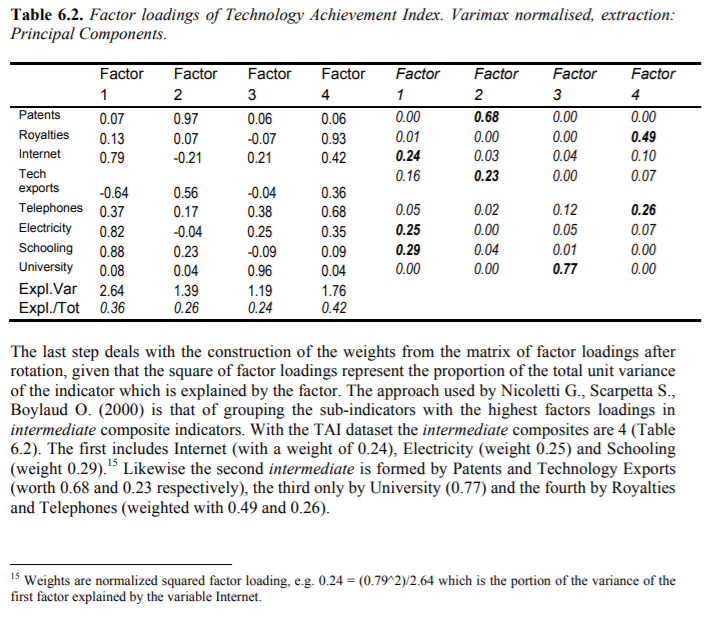

In [28]:
#compute the weights using the method stated in the footnote
vari_max=load.copy()
var_explained=vari_max[14:15]
vari_max=vari_max[:14]
vari_max['Factors 1']=vari_max['Factors 1']**2/var_explained['Factors 1'][0]
vari_max['Factors 2']=vari_max['Factors 2']**2/var_explained['Factors 2'][0]
vari_max['Factors 3']=vari_max['Factors 3']**2/var_explained['Factors 3'][0]

In [29]:
vari_max

Factors 1  \
cols                                                                                        
Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX               0.019866   
Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS   0.001253   
pol_gen                                                                          0.029234   
exl_gen                                                                          0.090731   
exl_eco                                                                          0.134309   
exl_geo                                                                          0.135653   
exl_pol                                                                          0.100612   
exl_soc                                                                          0.116787   
labour_share                                                                     0.000006   
suffrage_f                                                                       0.000423   
domestic_movement                                                                0.014463   
slave                                                                            0.012638   
suffrage                                                                         0.000424   
v2xeg_eqaccess                                                                   0.048717   

                                                                                Factors 2  \
cols                                                                                        
Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX               0.045894   
Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS   0.008458   
pol_gen                                                                          0.108289   
exl_gen                                                                          0.036479   
exl_eco                                                                          0.008645   
exl_geo                                                                          0.005023   
exl_pol                                                                          0.011650   
exl_soc                                                                          0.019342   
labour_share                                                                     0.000148   
suffrage_f                                                                       0.009504   
domestic_movement                                                                0.099185   
slave                                                                            0.096307   
suffrage                                                                         0.009485   
v2xeg_eqaccess                                                                   0.058116   

                                                                                Factors 3  
cols                                                                                       
Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX               0.012118  
Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS   0.001339  
pol_gen                                                                          0.016612  
exl_gen                                                                          0.004361  
exl_eco                                                                          0.000068  
exl_geo                                                                          0.000176  
exl_pol                                                                          0.001894  
exl_soc                                                                          0.006785  
labour_share                                                                     0.000032  
suffrage_f                                                                       0.277360 

Recreating this table:

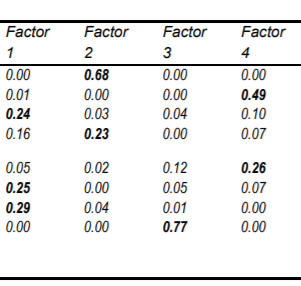

In [30]:
vari_max.style.highlight_max(color = 'lightgreen', axis = 1)

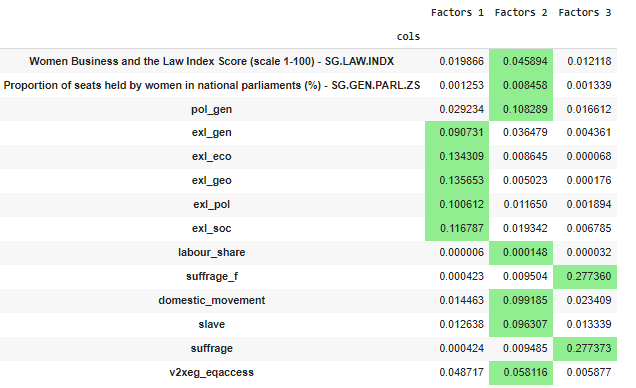

**Interpretation of factor loadings**
- Determine the factor that has the most influence on each variable: Loadings close to -1 or 1 indicate that the factor strongly influences the variable. Loadings close to 0 indicate that the factor has a weak influence on the variable. Some variables may have high loadings on multiple factors.


*   Exclusion by gender(0.09), socialeconomic position(0.13), urban-rural population(0.14), political group(0.10) and social group(0.12) have large positive loadings on factor 1, so this factor describes whether the state discriminates against individuals based on their identity or belonging to a
particular group, i.e. the extent to which public policy actively deny access to services or participation in
governed spaces (spaces that are part of the public space and the government should regulate). This seems to be the bare minimum of what we would expect from a country that has low inequality. 
According to the vdem codebook, these exclusion indicies measure
  *   whether individuals are excluded from positions of
power
  *   whether they enjoy the same level of civil liberties/state’s protection of rights and freedoms
  *   access to public services, state jobs and business opportunities




*  The variables that load heavily on factor 2 relate to the politicoeconomic conditions of the country. Factor 1 focuses on unequal treatment in the public space and the state's capacity to discriminate. Since the private sphere is likely to follow state policy, we can also infer that factor 1 would implicate the potential/possibility of individuals being treated unequally in the private sphere. Whereas, factor 2 describes the actual state of affairs in both the public and private spheres. It looks at things such as do women actually take part in the political decision-making process or are they paid the same amount as men, even if on paper men and women enjoy the same rights and opportunities. And how much power the groups actually wield in reality. Not being denied access to opportunities does not necessarily mean political power is evenly distributed between groups. I would consider it as a step-up in equality compared to what is described by factor 1. In a way, factor 2 describes the representation of groups in political and economic institutions. Variables for factor 2:
  *   the laws and regulations that affect women’s economic opportunity(Mobility, Workplace, Pay, Marriage, Parenthood, Entrepreneurship, Assets, and Pension)
 *   women participation in political institution
 *   how much income the citizen receives in proportion to GDP
 *   the extent to which citizens are able to move freely within a country
  *  freedom from forced labour- unable to quit a job s/he desires to leave — not by reason of economic necessity but rather by reason of employer’s coercion
  *  political equality(equal access index)- whether a certain group of individuals have a dominant hold on political power



*  Factor 3 describes whether the people have the basic political right to vote. This factor is almost like a proxy variable for regime type



*   Together, all three factors explain 73% of the variation in the data.












Following the approach in the paper, the highest factor loading for each indicator is selected as the weighting in each intermediate. For example, the third intermediate is formed by female suffrage and suffrage

**Aggregting the intermediate composites**

In [31]:
load[15:16]

Factors 1  Factors 2  Factors 3
cols                                               
prop_var_explained   0.425101   0.351974   0.222925

In [32]:
#multiply the weights to the raw dataframe for each intermediate
#first intermediate	
full['first']=0.090731	*full['exl_gen'] + 0.134309	*full['exl_eco'] + 0.135653*full['exl_geo'] + 0.100612 *full['exl_pol']+ 0.116787*full['exl_soc']
#second intermediate
full['second']=0.045894*full['Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX'] + 0.008458	*full['Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS']+ 0.108289*full['pol_gen'] + 0.000148*full['labour_share']+ 0.099185 *full['domestic_movement']+ 0.096307*full['slave']+ 	0.058116*full['v2xeg_eqaccess']                      	
#third intermediate
full['third']=  0.277360*full['suffrage_f']+ 0.277373*full['suffrage']
#perform aggregation using the prop of variance explained by each factor
full['index']= full['first']*0.425101	 + full['second']*0.351974 + full['third']*0.222925





*  Even though factor 1 explains the majority of the variance(~43%) in the dataset, when we look at the individual indicators, the variable suffrage of factor 3 gives the highest weighting(0.277373*0.222925=0.062). It appears that factor 3 explains more of a distict concept from factor 1 & 2(there are more overlaps in what 1 & 2 describe) - the concept of political right to vote. So whether a country is a democracy or not seems to be a key criteria for equality in the index. 
*  Second highest loading : exl_geo(exclusion by urban-rural population 0.135653*0.425101	=0.058)


* third highest loading : pol_gen(Women political empowerment index 0.108289**0.351974=0.038)






In [33]:
full.head()

Country Name Country Code      Continent  Year  \
2                Angola          AGO         Africa  2000   
3               Albania          ALB         Europe  2000   
5  United Arab Emirates          ARE           Asia  2000   
6             Argentina          ARG  South America  2000   
7               Armenia          ARM           Asia  2000   

   Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX  \
2                                                             0.62500   
3                                                             0.80000   
5                                                             0.26875   
6                                                             0.65000   
7                                                             0.58750   

   Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS  \
2                                                                        0.154545   
3                                                                        0.051613   
5                                                                        0.000000   
6                                                                        0.264591   
7                                                                        0.030534   

   pol_gen  exl_gen  exl_eco  exl_geo  ...  labour_share  suffrage_f  \
2    0.484    0.369    0.163    0.069  ...      0.372400         1.0   
3    0.686    0.727    0.697    0.855  ...      0.922612         1.0   
5    0.250    0.420    0.588    0.660  ...      0.914518         0.0   
6    0.861    0.919    0.733    0.828  ...      0.835182         1.0   
7    0.695    0.659    0.561    0.720  ...      0.870111         1.0   

   domestic_movement  slave  suffrage  v2xeg_eqaccess     first    second  \
2              0.138  0.531       1.0           0.303  0.101095  0.164894   
3              0.829  0.641       1.0           0.684  0.430045  0.295283   
5              0.291  0.171       0.0           0.168  0.276264  0.094636   
6              0.933  0.816       1.0           0.866  0.495545  0.346884   
7              0.924  0.833       1.0           0.510  0.408147  0.304120   

      third     index  
2  0.554733  0.224678  
3  0.554733  0.410408  
5  0.000000  0.150749  
6  0.554733  0.456415  
7  0.554733  0.404210  

[5 rows x 22 columns]

In [34]:
full.describe()

Year  \
count  2540.00000   
mean   2009.25315   
std       5.39741   
min    2000.00000   
25%    2005.00000   
50%    2009.00000   
75%    2014.00000   
max    2018.00000   

       Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX  \
count                                                         2540.000000   
mean                                                             0.710876   
std                                                              0.176261   
min                                                              0.237500   
25%                                                              0.618750   
50%                                                              0.731250   
75%                                                              0.843750   
max                                                              1.000000   

       Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS  \
count                                                                     2540.000000   
mean                                                                         0.187441   
std                                                                          0.113521   
min                                                                          0.000000   
25%                                                                          0.101059   
50%                                                                          0.171300   
75%                                                                          0.257606   
max                                                                          0.637500   

           pol_gen      exl_gen      exl_eco      exl_geo      exl_pol  \
count  2540.000000  2540.000000  2540.000000  2540.000000  2540.000000   
mean      0.760639     0.696075     0.636974     0.651158     0.662145   
std       0.159151     0.220251     0.254468     0.251150     0.264829   
min       0.105000     0.060000     0.042000     0.052000     0.067000   
25%       0.675000     0.556000     0.439000     0.485000     0.456000   
50%       0.798000     0.712000     0.663000     0.685500     0.702000   
75%       0.881250     0.909000     0.864000     0.900500     0.916000   
max       0.969000     0.987000     0.991000     0.969000     0.992000   

           exl_soc  labour_share   suffrage_f  domestic_movement        slave  \
count  2540.000000   2540.000000  2540.000000        2540.000000  2540.000000   
mean      0.659580      0.821688     0.954397           0.776779     0.723460   
std       0.246919      0.098979     0.203535           0.177764     0.186369   
min       0.066000      0.112994     0.000000           0.042000     0.026000   
25%       0.483000      0.785517     1.000000           0.725000     0.644000   
50%       0.694000      0.830576     1.000000           0.836000     0.755000   
75%       0.881500      0.873294     1.000000           0.901000     0.861000   
max       0.989000      1.326813     1.000000           0.958000     0.975000   

          suffrage  v2xeg_eqaccess        first       second        third  \
count  2540.000000     2540.000000  2540.000000  2540.000000  2540.000000   
mean      0.954424        0.653349     0.380689     0.301390     0.529443   
std       0.203410        0.215835     0.133527     0.064509     0.112873   
min       0.000000        0.070000     0.059503     0.064081     0.000000   
25%       1.000000        0.510000     0.281644     0.269513     0.554733   
50%       1.000000        0.693000     0.384308     0.314278     0.554733   
75%       1.000000        0.830000     0.511222     0.350090     0.554733   
max       1.000000        0.976000     0.566689     0.395248     0.554733   

             index  
count  2540.000000  
mean      0.385939  
std       0.084460  
min       0.099631  
25%       0.334075  
50%       0.388624  
75%       0.459278  
max       0.503131

In [35]:
# Assign ranking
full['Rank'] = full['index'].rank(ascending = False)
full = full.sort_values(by = 'Rank').reset_index()
full['index'] =round(full['index']-0.099631,5) # minus the min value so the index starts from zero

In [36]:
full.head()

level_0 Country Name Country Code Continent  Year  \
0     3848      Denmark          DNK    Europe  2018   
1     3215      Denmark          DNK    Europe  2015   
2     3426      Denmark          DNK    Europe  2016   
3     3637      Denmark          DNK    Europe  2017   
4     2039       Norway          NOR    Europe  2009   

   Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX  \
0                                                             1.00000   
1                                                             1.00000   
2                                                             1.00000   
3                                                             1.00000   
4                                                             0.96875   

   Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS  \
0                                                                        0.374302   
1                                                                        0.374302   
2                                                                        0.374302   
3                                                                        0.374302   
4                                                                        0.396450   

   pol_gen  exl_gen  exl_eco  ...  suffrage_f  domestic_movement  slave  \
0    0.969    0.987    0.991  ...         1.0              0.917  0.971   
1    0.966    0.987    0.991  ...         1.0              0.917  0.971   
2    0.966    0.987    0.991  ...         1.0              0.917  0.971   
3    0.967    0.987    0.991  ...         1.0              0.917  0.971   
4    0.955    0.980    0.987  ...         1.0              0.935  0.927   

   suffrage  v2xeg_eqaccess     first    second     third    index  Rank  
0       1.0           0.975  0.565396  0.395248  0.554733  0.40350   1.0  
1       1.0           0.976  0.565396  0.394982  0.554733  0.40341   2.0  
2       1.0           0.976  0.565396  0.394982  0.554733  0.40341   3.0  
3       1.0           0.962  0.564929  0.394275  0.554733  0.40296   4.0  
4       1.0           0.975  0.566689  0.390021  0.554733  0.40221   5.0  

[5 rows x 24 columns]

In [37]:
final_index=full.rename(columns={'index':'Composite_index'})

In [38]:
final_index.head(50)

level_0 Country Name Country Code Continent  Year  \
0      3848      Denmark          DNK    Europe  2018   
1      3215      Denmark          DNK    Europe  2015   
2      3426      Denmark          DNK    Europe  2016   
3      3637      Denmark          DNK    Europe  2017   
4      2039       Norway          NOR    Europe  2009   
5       984       Norway          NOR    Europe  2004   
6      1195       Norway          NOR    Europe  2005   
7      1406       Norway          NOR    Europe  2006   
8       773       Norway          NOR    Europe  2003   
9      1617       Norway          NOR    Europe  2007   
10     1828       Norway          NOR    Europe  2008   
11     3938       Norway          NOR    Europe  2018   
12     3845      Germany          DEU    Europe  2018   
13     3423      Germany          DEU    Europe  2016   
14     3212      Germany          DEU    Europe  2015   
15     2582      Denmark          DNK    Europe  2012   
16     3004      Denmark          DNK    Europe  2014   
17     3634      Germany          DEU    Europe  2017   
18      140       Norway          NOR    Europe  2000   
19     2793      Denmark          DNK    Europe  2013   
20     3727       Norway          NOR    Europe  2017   
21      562       Norway          NOR    Europe  2002   
22     2790      Germany          DEU    Europe  2013   
23     3001      Germany          DEU    Europe  2014   
24      351       Norway          NOR    Europe  2001   
25     2250       Norway          NOR    Europe  2010   
26     2672       Norway          NOR    Europe  2012   
27     2461       Norway          NOR    Europe  2011   
28     2371      Denmark          DNK    Europe  2011   
29     2707       Sweden          SWE    Europe  2012   
30     2160      Denmark          DNK    Europe  2010   
31     1949      Denmark          DNK    Europe  2009   
32     1738      Denmark          DNK    Europe  2008   
33     2368      Germany          DEU    Europe  2011   
34     2579      Germany          DEU    Europe  2012   
35     2157      Germany          DEU    Europe  2010   
36     1946      Germany          DEU    Europe  2009   
37     2496       Sweden          SWE    Europe  2011   
38     3516       Norway          NOR    Europe  2016   
39     3305       Norway          NOR    Europe  2015   
40     2883       Norway          NOR    Europe  2013   
41     3094       Norway          NOR    Europe  2014   
42      894      Denmark          DNK    Europe  2004   
43       50      Denmark          DNK    Europe  2000   
44     1735      Germany          DEU    Europe  2008   
45     1105      Denmark          DNK    Europe  2005   
46     1527      Denmark          DNK    Europe  2007   
47     1524      Germany          DEU    Europe  2007   
48      683      Denmark          DNK    Europe  2003   
49      472      Denmark          DNK    Europe  2002   

    Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX  \
0                                                              1.00000   
1                                                              1.00000   
2                                                              1.00000   
3                                                              1.00000   
4                                                              0.96875   
5                                                              0.94375   
6                                                              0.94375   
7                                                              0.94375   
8                                                              0.94375   
9                                                              0.94375   
10                                                             0.94375   
11                                                             0.96875   
12                                                             0.97500   
13                                                          

In [39]:
final_index.tail(50)

level_0          Country Name Country Code      Continent  Year  \
2490     1482  United Arab Emirates          ARE           Asia  2007   
2491     2339               Bahrain          BHR           Asia  2011   
2492     2550               Bahrain          BHR           Asia  2012   
2493     1423                 Qatar          QAT           Asia  2006   
2494     2761               Bahrain          BHR           Asia  2013   
2495      582                Rwanda          RWA         Africa  2002   
2496      371                Rwanda          RWA         Africa  2001   
2497     1271  United Arab Emirates          ARE           Asia  2006   
2498      160                Rwanda          RWA         Africa  2000   
2499     1060  United Arab Emirates          ARE           Asia  2005   
2500     1704            Bangladesh          BGD           Asia  2008   
2501     3959          Saudi Arabia          SAU           Asia  2018   
2502     2651            Madagascar          MDG         Africa  2012   
2503     2440            Madagascar          MDG         Africa  2011   
2504     3748          Saudi Arabia          SAU           Asia  2017   
2505     3326          Saudi Arabia          SAU           Asia  2015   
2506     3537          Saudi Arabia          SAU           Asia  2016   
2507     3115          Saudi Arabia          SAU           Asia  2014   
2508     2904          Saudi Arabia          SAU           Asia  2013   
2509     2229            Madagascar          MDG         Africa  2010   
2510     2693          Saudi Arabia          SAU           Asia  2012   
2511     2482          Saudi Arabia          SAU           Asia  2011   
2512     2271          Saudi Arabia          SAU           Asia  2010   
2513     1137                 Haiti          HTI  North America  2005   
2514      638  United Arab Emirates          ARE           Asia  2003   
2515      216  United Arab Emirates          ARE           Asia  2001   
2516      427  United Arab Emirates          ARE           Asia  2002   
2517        5  United Arab Emirates          ARE           Asia  2000   
2518     2060          Saudi Arabia          SAU           Asia  2009   
2519     1849          Saudi Arabia          SAU           Asia  2008   
2520      849  United Arab Emirates          ARE           Asia  2004   
2521     1638          Saudi Arabia          SAU           Asia  2007   
2522     1427          Saudi Arabia          SAU           Asia  2006   
2523     1216          Saudi Arabia          SAU           Asia  2005   
2524      528               Liberia          LBR         Africa  2002   
2525      739               Liberia          LBR         Africa  2003   
2526     1005          Saudi Arabia          SAU           Asia  2004   
2527      794          Saudi Arabia          SAU           Asia  2003   
2528       55               Eritrea          ERI         Africa  2000   
2529      266               Eritrea          ERI         Africa  2001   
2530      477               Eritrea          ERI         Africa  2002   
2531      688               Eritrea          ERI         Africa  2003   
2532      899               Eritrea          ERI         Africa  2004   
2533     2165               Eritrea          ERI         Africa  2010   
2534     1321               Eritrea          ERI         Africa  2006   
2535     1110               Eritrea          ERI         Africa  2005   
2536     1532               Eritrea          ERI         Africa  2007   
2537     1954               Eritrea          ERI         Africa  2009   
2538     1743               Eritrea          ERI         Africa  2008   
2539     2376               Eritrea          ERI         Africa  2011   

      Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX  \
2490                                                             0.26875   
2491                                                             0.31875   
2492                                                  

In [40]:
#take a look at the correlations
final_index[[
       'Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX',
       'Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS',
       'pol_gen', 'exl_gen', 'exl_eco', 'exl_geo', 'exl_pol', 'exl_soc',
       'labour_share', 'suffrage_f', 'domestic_movement', 'slave', 'suffrage',
       'v2xeg_eqaccess', 'Composite_index', 'Rank']].corr()[14:15] #	exl_soc(exclusion by socialeconomic position) 0.905863	exl_gen(exclusion by gender)	0.889771 pol_gen(political by gender) 0.846554

Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX  \
Composite_index                                                            0.667538   

                 Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS  \
Composite_index                                                                        0.332943   

                  pol_gen   exl_gen   exl_eco   exl_geo  exl_pol   exl_soc  \
Composite_index  0.846554  0.889771  0.829841  0.792717  0.81029  0.905863   

                 labour_share  suffrage_f  domestic_movement     slave  \
Composite_index      0.021134    0.540347            0.72626  0.680228   

                 suffrage  v2xeg_eqaccess  Composite_index      Rank  
Composite_index  0.540356        0.800019              1.0 -0.969334

### Some visualisations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


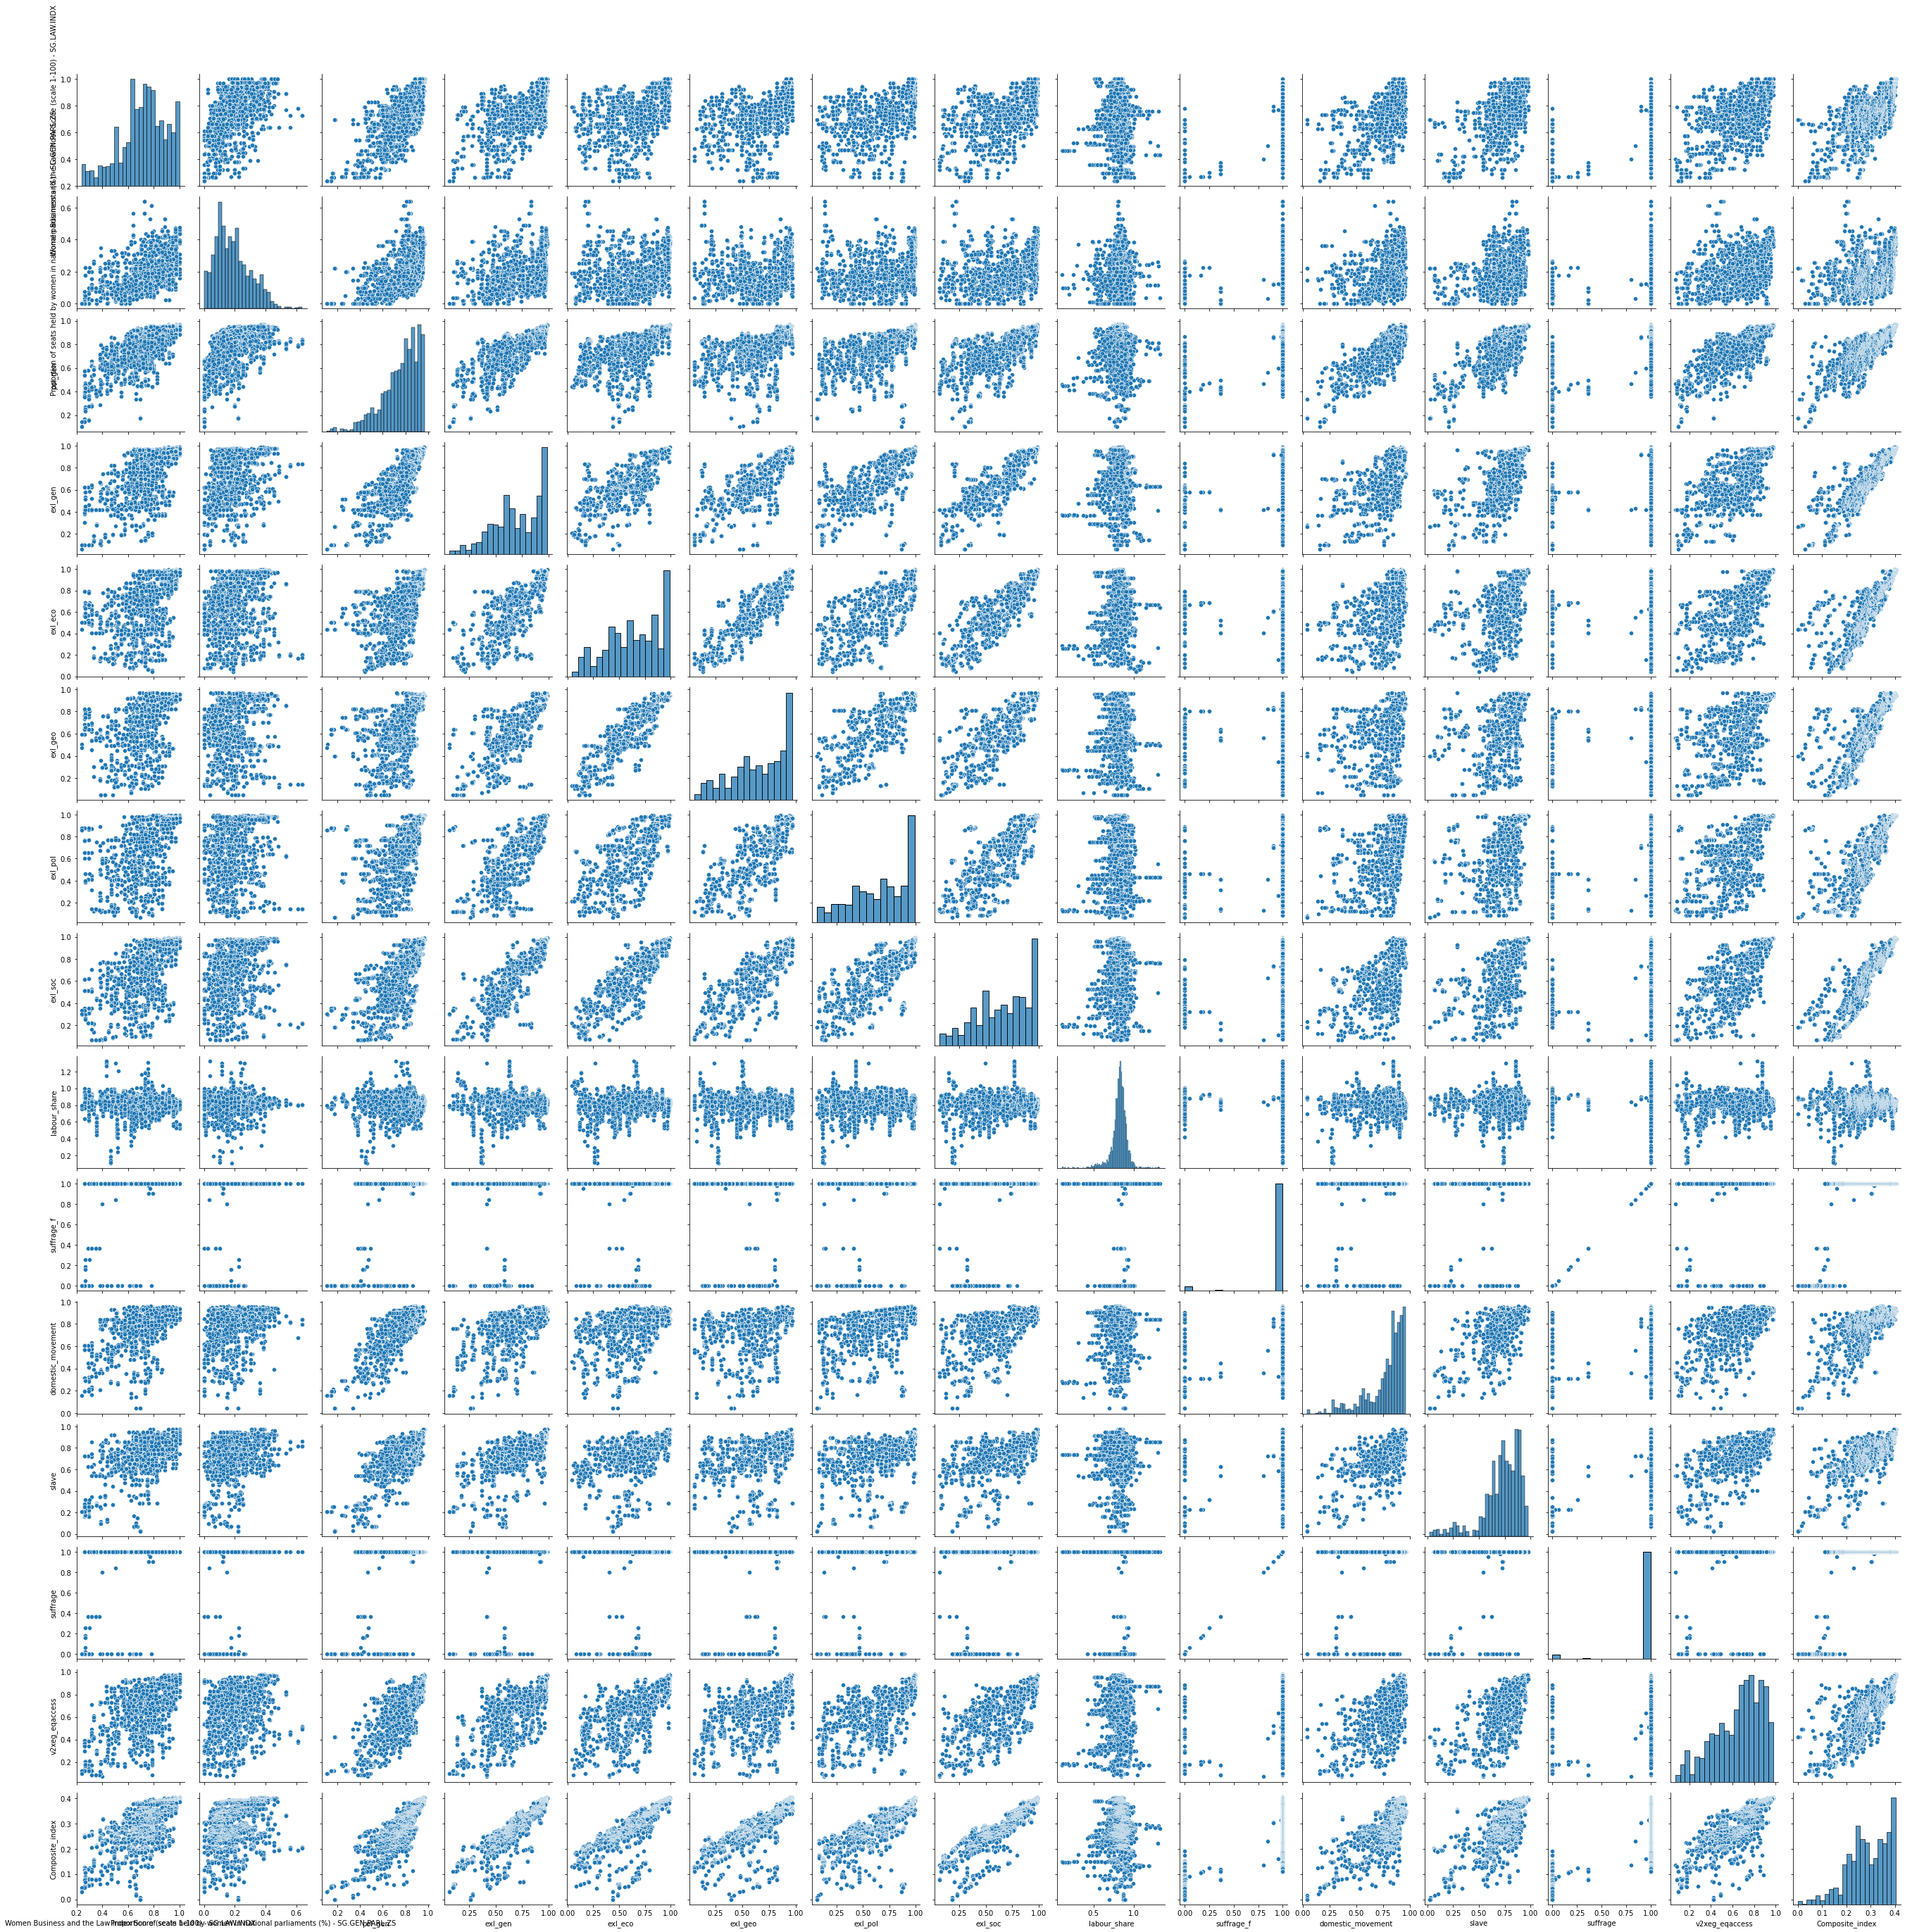

In [41]:
#plot pairpots
sns.pairplot(final_index[[
       'Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX',
       'Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS',
       'pol_gen', 'exl_gen', 'exl_eco', 'exl_geo', 'exl_pol', 'exl_soc',
       'labour_share', 'suffrage_f', 'domestic_movement', 'slave', 'suffrage',
       'v2xeg_eqaccess', 'Composite_index']])

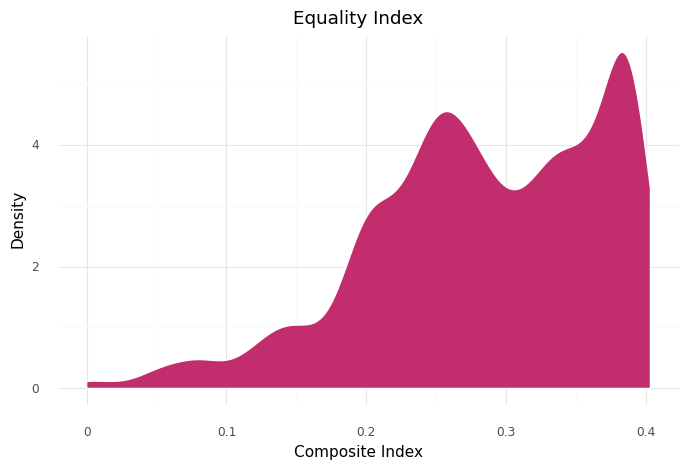

<ggplot: (8794062868402)>

In [42]:
# Plot distribution
from plotnine import ggplot, aes, geom_density, options,labs, xlab,ylab, theme_minimal
options.figure_size = (8, 4.8)
composite_index_distribution = (
    ggplot(data = final_index)+
    geom_density(aes(x = 'Composite_index'),
                 color = 'white',
                 fill = '#c22d6d')+
    labs(title = 'Equality Index')+
    xlab('Composite Index')+
    ylab('Density')+
    theme_minimal()
)

composite_index_distribution

**UK Trend**

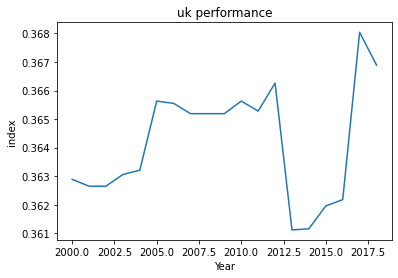

In [43]:
uk=final_index[final_index['Country Code']=='GBR'].sort_values('Year')

plt.plot(uk.Year,uk.Composite_index)
plt.title('uk performance')
plt.xlabel('Year')
plt.ylabel('index')
plt.show()

**Spain Trend**

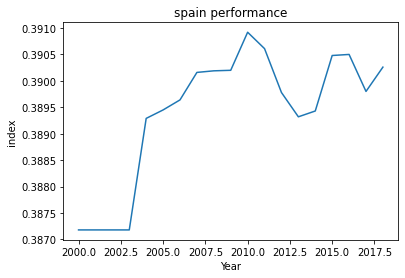

In [44]:
spain=final_index[final_index['Country Code']=='ESP'].sort_values('Year')

plt.plot(spain.Year,spain.Composite_index)
plt.title('spain performance')
plt.xlabel('Year')
plt.ylabel('index')
plt.show()

##### Look at which countries have the largest percentage difference in min max index score

In [45]:
#calculate percentage difference in min max index score
pg=final_index.groupby('Country Name')['Composite_index'].agg(['min','max'])
pg.columns

Index(['min', 'max'], dtype='object')

In [46]:
#find top 20 countries in terms of percenrage growth in index score
pg['pg']=((pg['max']-pg['min'])/pg['min'])*100
pg.sort_values('pg',ascending=False).head(20)

min      max          pg
Country Name                                      
Liberia               0.04482  0.24705  451.204819
Madagascar            0.05724  0.21954  283.542977
Nepal                 0.07989  0.29020  263.249468
Haiti                 0.05305  0.18663  251.800189
Rwanda                0.06784  0.20842  207.222877
Bangladesh            0.06324  0.19332  205.692600
Burundi               0.08689  0.21877  151.778110
United Arab Emirates  0.04990  0.12459  149.679359
Guinea-Bissau         0.09651  0.23695  145.518599
Bhutan                0.14175  0.33605  137.072310
Kuwait                0.11468  0.25392  121.416114
Comoros               0.11256  0.24379  116.586709
Jordan                0.12663  0.26840  111.956093
Saudi Arabia          0.02928  0.06104  108.469945
Lebanon               0.12228  0.25206  106.133464
Thailand              0.14820  0.28529   92.503374
Georgia               0.19117  0.35137   83.799759
Bahrain               0.07738  0.13656   76.479711
Lesotho               0.17333  0.30166   74.037962
Angola                0.12505  0.20169   61.287485

**Liberia**

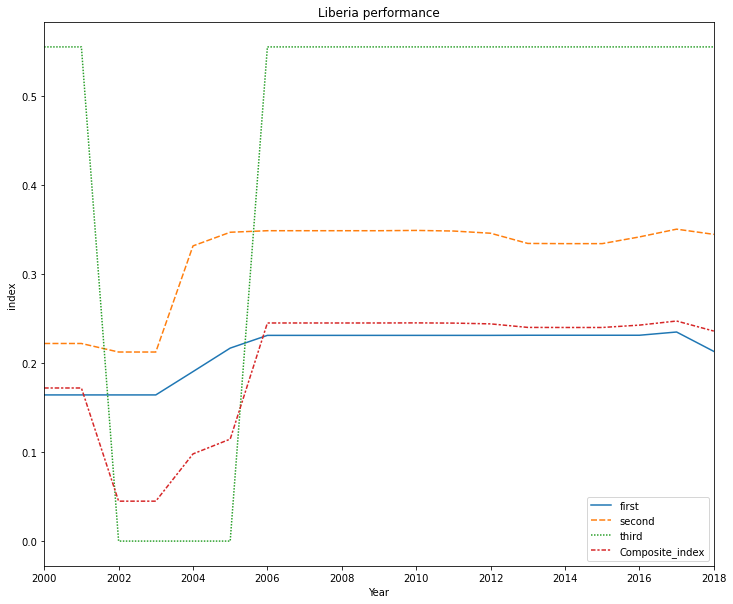

In [47]:
#plot the intermediates
cols=[ 'Year', 'first','second','third','Composite_index']
Liberia=final_index[final_index['Country Name']=='Liberia'].sort_values('Year')
Liberia=Liberia[cols].set_index('Year')
fig, ax = plt.subplots(figsize=(12, 10))
sns.lineplot(data=Liberia)
plt.title('Liberia performance')
plt.xlabel('Year')
plt.ylabel('index')
plt.xlim(2000, 2018)
plt.show()

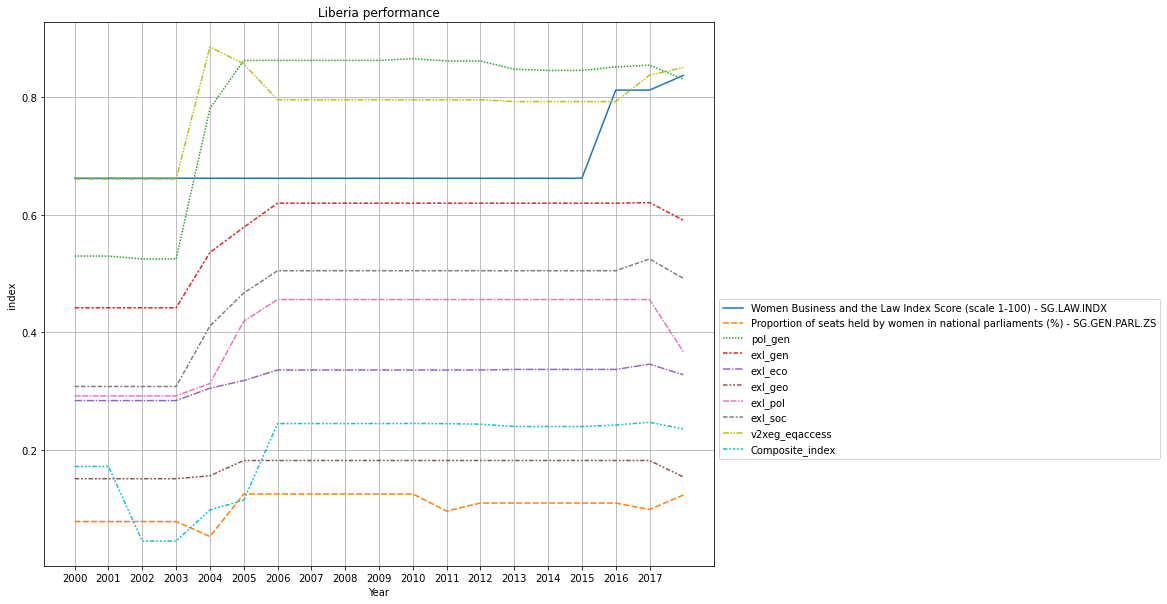

In [48]:
#plot underlying indicators of the second intermediate
cols=[ 'Year',
       'Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX',
       'Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS',
       'pol_gen', 'exl_gen', 'exl_eco', 'exl_geo', 'exl_pol', 'exl_soc',
       'v2xeg_eqaccess', 'Composite_index']
Liberia=final_index[final_index['Country Name']=='Liberia'].sort_values('Year')
Liberia=Liberia[cols].set_index('Year')
fig, ax = plt.subplots(figsize=(12, 10))
sns.lineplot(data=Liberia)
plt.title('Liberia performance')
plt.xlabel('Year')
plt.ylabel('index')
x_ticks = np.arange(2000,2018, 1)
plt.xticks(x_ticks)
plt.grid()
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()

In [49]:
Liberia

Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX  \
Year                                                                       
2000                                                              0.6625   
2001                                                              0.6625   
2002                                                              0.6625   
2003                                                              0.6625   
2004                                                              0.6625   
2005                                                              0.6625   
2006                                                              0.6625   
2007                                                              0.6625   
2008                                                              0.6625   
2009                                                              0.6625   
2010                                                              0.6625   
2011                                                              0.6625   
2012                                                              0.6625   
2013                                                              0.6625   
2014                                                              0.6625   
2015                                                              0.6625   
2016                                                              0.8125   
2017                                                              0.8125   
2018                                                              0.8375   

      Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS  \
Year                                                                                   
2000                                                                        0.078125   
2001                                                                        0.078125   
2002                                                                        0.078125   
2003                                                                        0.078125   
2004                                                                        0.052632   
2005                                                                        0.125000   
2006                                                                        0.125000   
2007                                                                        0.125000   
2008                                                                        0.125000   
2009                                                                        0.125000   
2010                                                                        0.125000   
2011                                                                        0.095890   
2012                                                                        0.109589   
2013                                                                        0.109589   
2014                                                                        0.109589   
2015                                                                        0.109589   
2016                                                                        0.109589   
2017                                                                        0.098592   
2018                                                                        0.123288   

      pol_gen  exl_gen  exl_eco  exl_geo  exl_pol  exl_soc  v2xeg_eqaccess  \
Year                                                                         
2000    0.530    0.442    0.284    0.151    0.292    0.308           0.661   
2001    0.530    0.442    0.284    0.151    0.292    0.308           0.661   
2002    0.525    0.442    0.284    0.151    0.292    0.308           0.661   
2003    0.525    0.442    0.284    0.151    0.292    0.308           0.661   
2004    0.781    0.536    0.305    0.156    0.313    0.411           0.886   
2005    0.863 

**Madagascar**

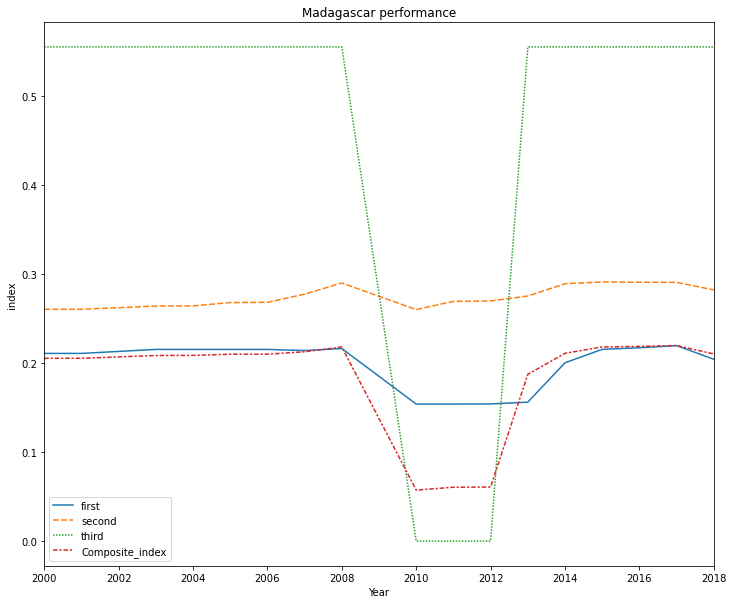

In [50]:
#plot intermediates
cols=[ 'Year','first', 'second', 'third', 'Composite_index']
Madagascar=final_index[final_index['Country Name']=='Madagascar'].sort_values('Year')
Madagascar=Madagascar[cols].set_index('Year')
fig, ax = plt.subplots(figsize=(12, 10))
sns.lineplot(data=Madagascar)
plt.title('Madagascar performance')
plt.xlabel('Year')
plt.ylabel('index')
plt.xlim(2000, 2018)
plt.show()

In [51]:
Madagascar

first    second     third  Composite_index
Year                                               
2000  0.210678  0.260174  0.554733          0.20517
2001  0.210678  0.260266  0.554733          0.20520
2003  0.215158  0.263778  0.554733          0.20834
2004  0.215158  0.264043  0.554733          0.20843
2005  0.215158  0.267777  0.554733          0.20975
2006  0.215158  0.267993  0.554733          0.20982
2007  0.213846  0.277186  0.554733          0.21250
2008  0.216155  0.289724  0.554733          0.21790
2010  0.153820  0.259904  0.000000          0.05724
2011  0.153820  0.269109  0.000000          0.06048
2012  0.153954  0.269528  0.000000          0.06068
2013  0.155972  0.275088  0.554733          0.18716
2014  0.200174  0.288906  0.554733          0.21081
2015  0.215261  0.290863  0.554733          0.21792
2016  0.217013  0.290538  0.554733          0.21855
2017  0.219428  0.290429  0.554733          0.21954
2018  0.204111  0.281977  0.554733          0.21005

#### Plot the contribution of intermediates to the index

In [52]:
for_con=final_index.copy()

In [53]:
#multiply the intermediates with the prop of variance explained
for_con['first']=(0.090731	*for_con['exl_gen'] + 0.134309	*for_con['exl_eco'] + 0.135653*for_con['exl_geo'] + 0.100612 *for_con['exl_pol']+ 0.116787*for_con['exl_soc'])*0.425101
#second intermediate
for_con['second']=(0.045894*for_con['Women Business and the Law Index Score (scale 1-100) - SG.LAW.INDX'] + 0.008458	*for_con['Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS']+ 0.108289*for_con['pol_gen'] + 0.000148*for_con['labour_share']+ 0.099185 *for_con['domestic_movement']+ 0.096307*for_con['slave']+ 	0.058116*for_con['v2xeg_eqaccess'])*0.351974                       	
#third intermediate
for_con['third']= (0.277360*for_con['suffrage_f']+ 0.277373*for_con['suffrage'])*0.222925

top 50 countries in 2018

In [54]:
# Redefine the data
df_index_reverse=for_con[for_con.Year==2018].head(50).sort_values(by = 'Rank', ascending = False).reset_index(drop = True)
facs=['first','second','third']
df_contribution = pd.melt(frame = df_index_reverse,
                          id_vars = ['Country Name','Year'],
                          value_vars = facs,
                          var_name = 'Factor',
                          value_name = 'Factor Value')
df_contribution

Country Name  Year Factor  Factor Value
0         Bhutan  2018  first      0.201033
1        Romania  2018  first      0.194387
2          Ghana  2018  first      0.196800
3         Israel  2018  first      0.198714
4        Armenia  2018  first      0.193530
..           ...   ...    ...           ...
145      Finland  2018  third      0.123664
146       Sweden  2018  third      0.123664
147      Germany  2018  third      0.123664
148       Norway  2018  third      0.123664
149      Denmark  2018  third      0.123664

[150 rows x 4 columns]

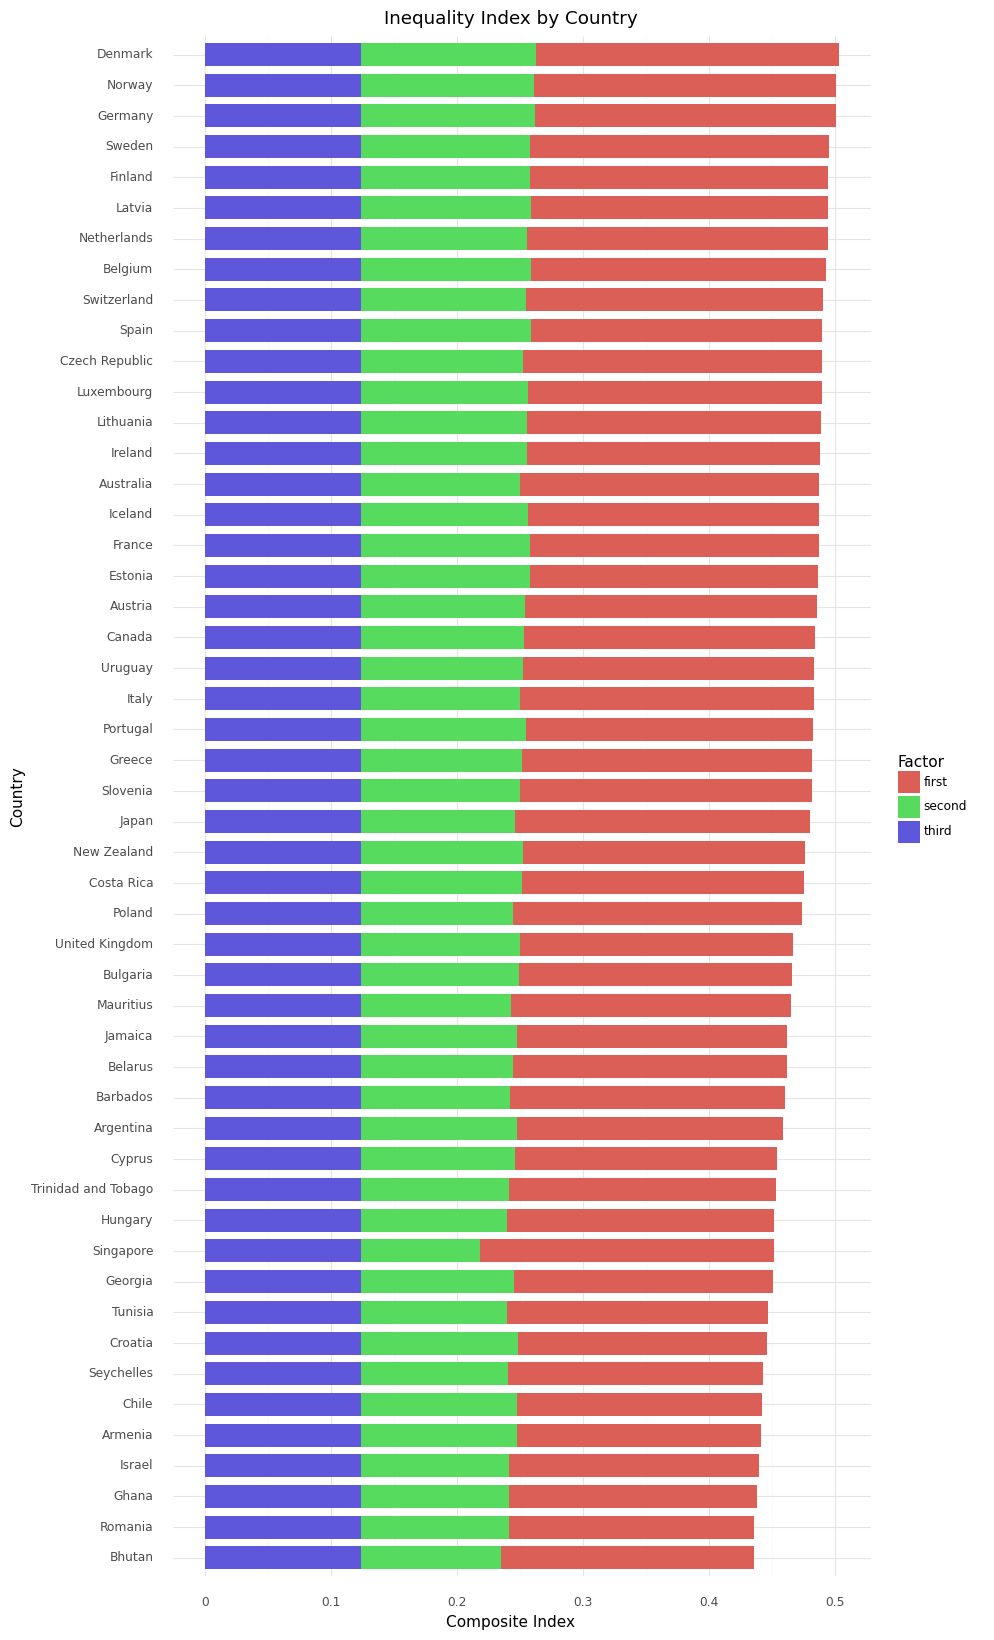

<ggplot: (8794040631531)>

In [55]:
from plotnine import geom_bar, scale_x_discrete, coord_flip, options, ggplot,aes,labs, xlab, ylab, theme_minimal
options.figure_size = (9, 20)
contribution_factors_composite_index = (
    ggplot(data = df_contribution)+
    geom_bar(aes(x = 'Country Name',
                 y = 'Factor Value',
                 fill = 'Factor'),
             width = 0.75,
             position = 'stack',
             stat = 'identity')+
    scale_x_discrete(limits = df_index_reverse['Country Name'].tolist())+
    labs(title = 'Inequality Index by Country')+
    xlab('Country')+
    ylab('Composite Index')+
    coord_flip()+
    theme_minimal()
)
# Display the viz
contribution_factors_composite_index


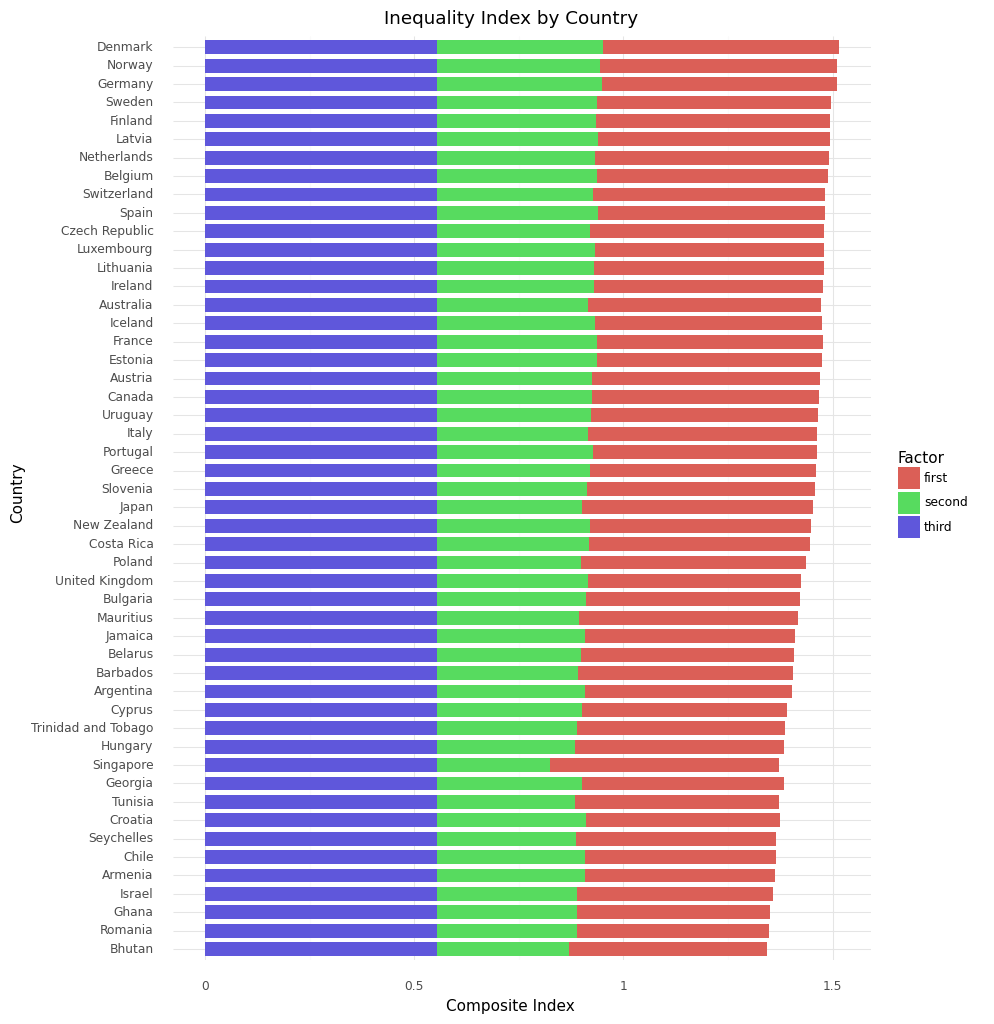

#### Bottom 50 countries in 2018

In [56]:
# Redefine the data
df_index_reverse=for_con[for_con.Year==2018].tail(10).sort_values(by = 'Rank', ascending = False).reset_index(drop = True)
facs=['first','second','third']
df_contribution = pd.melt(frame = df_index_reverse,
                          id_vars = ['Country Name','Year'],
                          value_vars = facs,
                          var_name = 'Factor',
                          value_name = 'Factor Value')
df_contribution


Country Name  Year  Factor  Factor Value
0           Saudi Arabia  2018   first      0.124674
1                  Qatar  2018   first      0.142512
2             Mauritania  2018   first      0.026615
3   United Arab Emirates  2018   first      0.143773
4             Tajikistan  2018   first      0.038151
5                Bahrain  2018   first      0.080282
6                   Iraq  2018   first      0.039036
7      Equatorial Guinea  2018   first      0.060488
8                   Chad  2018   first      0.052729
9             Bangladesh  2018   first      0.052442
10          Saudi Arabia  2018  second      0.035998
11                 Qatar  2018  second      0.040765
12            Mauritania  2018  second      0.071139
13  United Arab Emirates  2018  second      0.049284
14            Tajikistan  2018  second      0.067725
15               Bahrain  2018  second      0.056982
16                  Iraq  2018  second      0.074086
17     Equatorial Guinea  2018  second      0.064733
18                  Chad  2018  second      0.076148
19            Bangladesh  2018  second      0.086908
20          Saudi Arabia  2018   third      0.000000
21                 Qatar  2018   third      0.000000
22            Mauritania  2018   third      0.123664
23  United Arab Emirates  2018   third      0.031163
24            Tajikistan  2018   third      0.123664
25               Bahrain  2018   third      0.098931
26                  Iraq  2018   third      0.123664
27     Equatorial Guinea  2018   third      0.123664
28                  Chad  2018   third      0.123664
29            Bangladesh  2018   third      0.123664

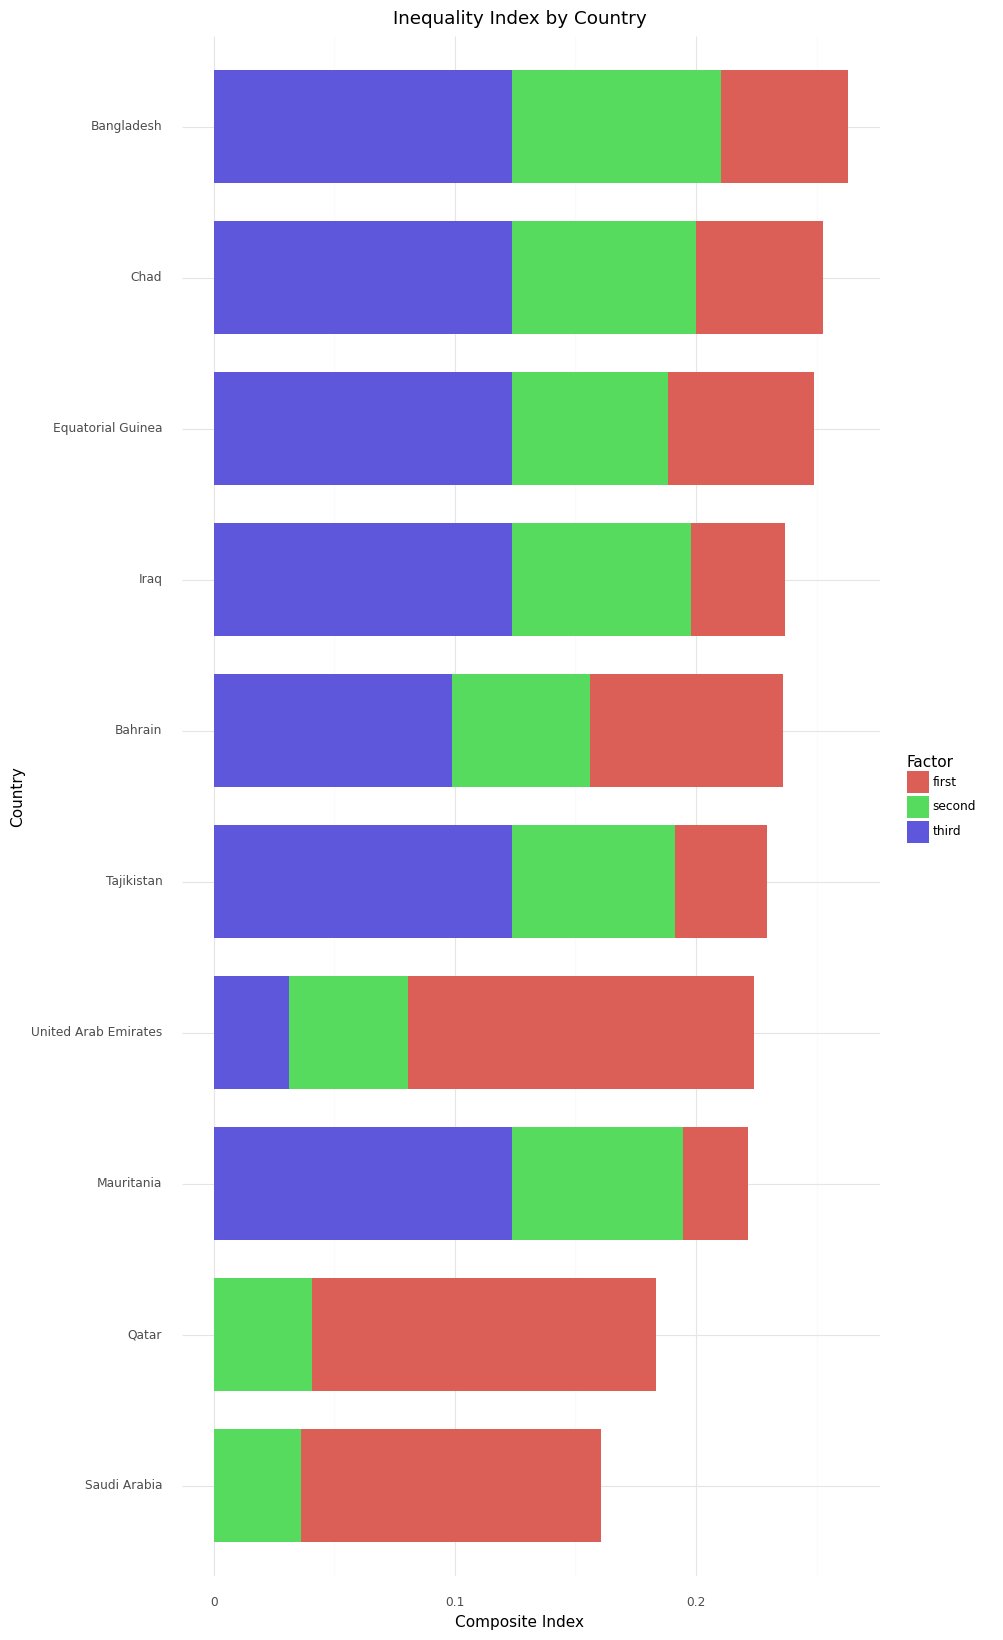

<ggplot: (8794040663998)>

In [57]:
from plotnine import geom_bar, scale_x_discrete, coord_flip, options, ggplot,aes,labs, xlab, ylab, theme_minimal
options.figure_size = (9, 20)
contribution_factors_composite_index = (
    ggplot(data = df_contribution)+
    geom_bar(aes(x = 'Country Name',
                 y = 'Factor Value',
                 fill = 'Factor'),
             width = 0.75,
             position = 'stack',
             stat = 'identity')+
    scale_x_discrete(limits = df_index_reverse['Country Name'].tolist())+
    labs(title = 'Inequality Index by Country')+
    xlab('Country')+
    ylab('Composite Index')+
    coord_flip()+
    theme_minimal()
)
# Display the viz
contribution_factors_composite_index


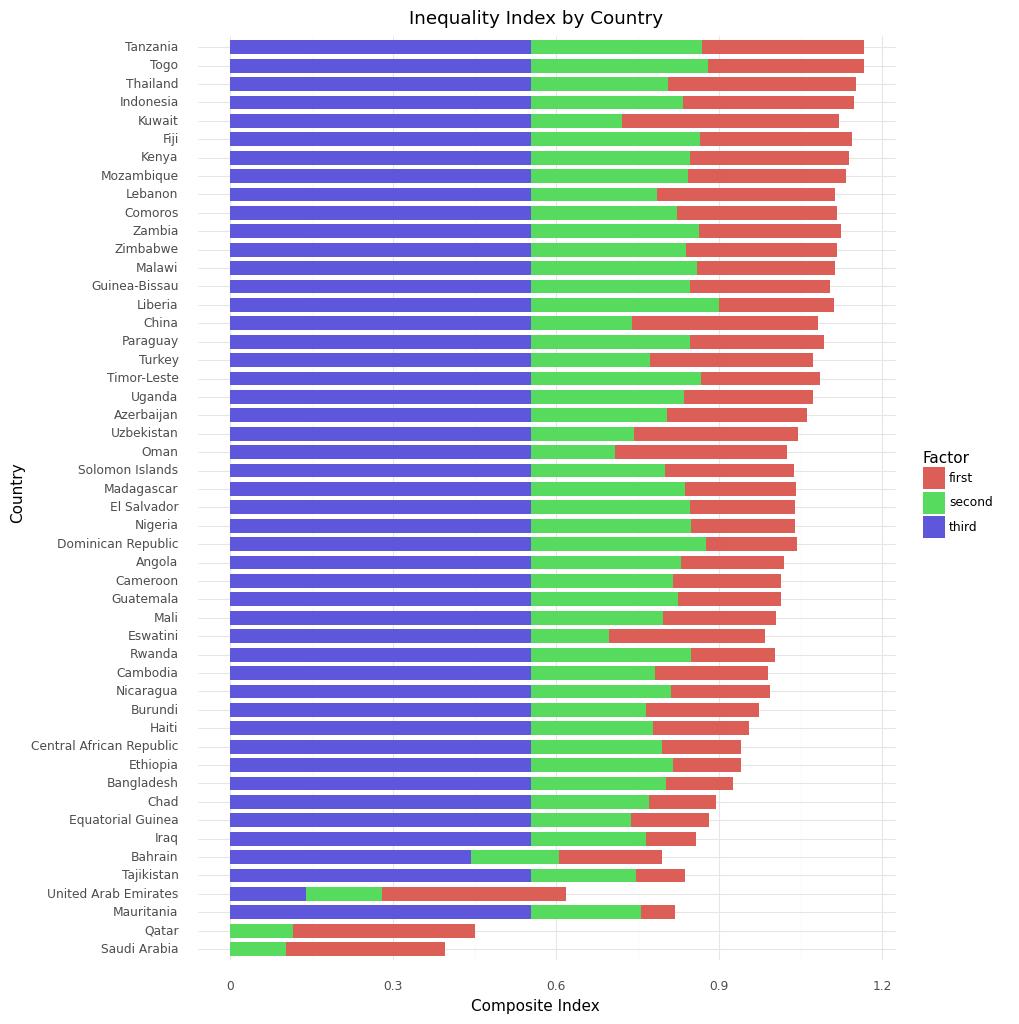